# Introduction to Convolution Neural Networks

## Import the libraries

In [69]:
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, array_to_img
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


import itertools
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

## Load the data

In [57]:
!ls data

In [58]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [59]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [60]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Pre-processing

In [61]:
random_seed = 121
X_train = train.drop(labels = ["label"], axis = 1)
Y_train = train["label"]

Y_train = to_categorical(Y_train,num_classes = 10)

In [62]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [63]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## Train Test Split 

In [64]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

In [65]:
print(X_train.shape)
print(X_train.shape)
print(X_val.shape)
print(Y_val.shape)

(37800, 28, 28, 1)
(37800, 28, 28, 1)
(4200, 28, 28, 1)
(4200, 10)


In [66]:
num_classes = 10
epochs = 3

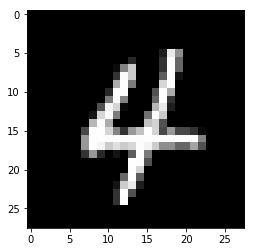

In [67]:
plt.imshow(X_train[0][:,:,0],cmap = 'gray');

## Create and compile the model.

In [71]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5),input_shape = (28,28,1),padding = 'same',activation = 'relu'))
model.add(MaxPool2D())
model.add(Conv2D(64,kernel_size = 5, padding  = 'same', activation = 'relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))
model.add(Dense(10,activation = 'softmax'))

In [72]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])


In [73]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              3212288   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10250     
Total para

## Train the model

In [75]:
history_cnn = model.fit(X_train,Y_train,epochs=5,verbose=1,validation_data=(X_val,Y_val))

Train on 37800 samples, validate on 4200 samples
Epoch 1/5
37800/37800 [==============================] - 123s 3ms/step - loss: 0.1205 - acc: 0.9618 - val_loss: 0.0560 - val_acc: 0.9829
Epoch 2/5
37800/37800 [==============================] - 120s 3ms/step - loss: 0.0407 - acc: 0.9879 - val_loss: 0.0493 - val_acc: 0.9843
Epoch 3/5
37800/37800 [==============================] - 128s 3ms/step - loss: 0.0290 - acc: 0.9914 - val_loss: 0.0349 - val_acc: 0.9874
Epoch 4/5
37800/37800 [==============================] - 133s 4ms/step - loss: 0.0222 - acc: 0.9930 - val_loss: 0.0415 - val_acc: 0.9879
Epoch 5/5
37800/37800 [==============================] - 123s 3ms/step - loss: 0.0147 - acc: 0.9951 - val_loss: 0.0379 - val_acc: 0.9900


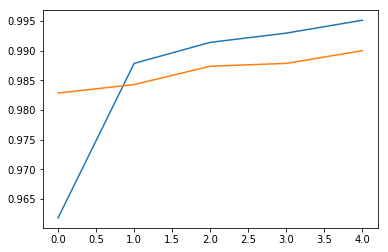

In [96]:
plt.plot(history_cnn.history['acc'])
plt.plot(history_cnn.history['val_acc'])


In [76]:
model.save_weights('weights/cnn-model5.h5')

In [81]:
model.load_weights('weights/cnn-model5.h5')

In [84]:
score = model.evaluate(X_val,Y_val)

4200/4200 [==============================] - 2s 439us/step


In [85]:
score

[0.037913036416024885, 0.99]

## Re -Train With Changes

In [113]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [114]:
epochs = 10
batch_size = 32

In [115]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [116]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
1181/1181 [==============================] - 120s 101ms/step - loss: 0.0372 - acc: 0.9883 - val_loss: 0.0343 - val_acc: 0.9907
Epoch 2/10
1181/1181 [==============================] - 120s 101ms/step - loss: 0.0299 - acc: 0.9907 - val_loss: 0.0264 - val_acc: 0.9933
Epoch 3/10
1181/1181 [==============================] - 116s 98ms/step - loss: 0.0259 - acc: 0.9921 - val_loss: 0.0277 - val_acc: 0.9921
Epoch 4/10
1181/1181 [==============================] - 107s 91ms/step - loss: 0.0264 - acc: 0.9920 - val_loss: 0.0241 - val_acc: 0.9940
Epoch 5/10
1181/1181 [==============================] - 107s 91ms/step - loss: 0.0241 - acc: 0.9923 - val_loss: 0.0216 - val_acc: 0.9948
Epoch 6/10
1181/1181 [==============================] - 118s 100ms/step - loss: 0.0203 - acc: 0.9937 - val_loss: 0.0308 - val_acc: 0.9917
Epoch 7/10
1181/1181 [==============================] - 125s 106ms/step - loss: 0.0209 - acc: 0.9938 - val_loss: 0.0241 - val_acc: 0.9940
Epoch 8/10
1181/1181 [===============

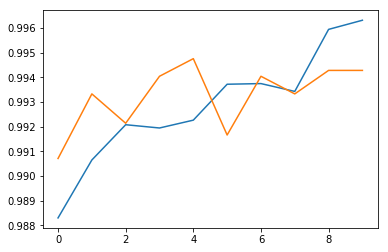

In [117]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

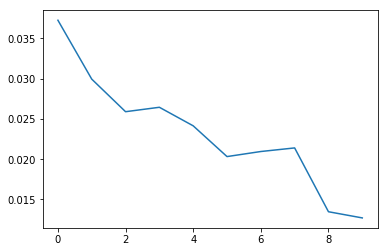

In [118]:
plt.plot(history.history['loss']);

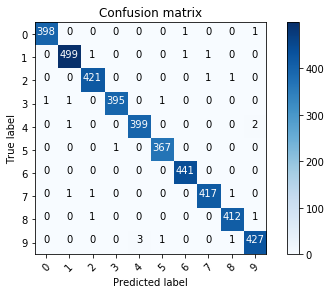

In [119]:
# Confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


In [120]:
model.save_weights('weights/cnn-finalmodel.h5')
model.load_weights('weights/cnn-finalmodel.h5')

In [121]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [122]:
final = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

final.to_csv("mnist_datagen.csv",index=False)